# Realigning and Coarsening Grids

## Imports

In [16]:
%matplotlib inline

import os

import rasterio
from rasterio.plot import show
from rasterio import warp
import gdal
import affine

import xarray as xr
import pandas as pd
import numpy as np
import sklearn as skl
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt

## Functions

In [2]:
def buildRasterAttributes(raster):
    # save all the useful attributes of a DEM raster as a dict
    attribs = {}
    attribs['count'] = raster.count
    attribs['width'] = raster.width
    attribs['height'] = raster.height
    attribs['bounds'] = raster.bounds
    attribs['transform'] = raster.transform
    attribs['affine'] = raster.affine
    attribs['crs'] = raster.crs
    attribs['nodata'] = raster.nodata
    return attribs

In [3]:
def buildAxesFromAttributes(attribs):
    # build a numpy array of a range of the coordinates for a given set of attributes
    # set to np.float32 to save space
    xaxis = (np.arange(attribs['affine'][2],
                      attribs['affine'][2] + (attribs['affine'][0] * attribs['width']),
                      attribs['affine'][0])).astype(np.float32)
    yaxis = (np.arange(attribs['affine'][5],
                      attribs['affine'][5] + (attribs['affine'][4] * attribs['height']),
                      attribs['affine'][4])).astype(np.float32)
    return xaxis, yaxis

# Building the Lists of data to be loaded
Result should a be a dict, with the name of the data as a key, and the full path to the file as the value

In [197]:
# define where the DEM data lives
dem_dir = r'\\prod.lan\active\proj\futurex\StuartCorridor\Working\Mike\KeyData\\'
# define the DEM files to be opened
dem_files = {'elevation':'tt_dem_rescaled.tif', 'aspect': 'tt_dem_aspect_rescaled.tif', 'slope': 'tt_dem_slope_rescaled.tif'}
dem_paths = {data : dem_dir + file for data, file in dem_files.items()}

aem_dir = r'\\prod.lan\active\proj\futurex\StuartCorridor\Data\Processed\Geophysics\AEM\NBC_inversion\line_data_cor2DLog\grids\TT_layers_log\\'
aem_filenames = [file for file in os.listdir(aem_dir) if file[-4::] == '.ers']
aem_filenames.sort()
aem_top_depths = [float(file[9:14]) for file in aem_filenames]
aem_layernames = ['conductivity' + str(i+1) +'_' + str(depth) for i, depth in enumerate(aem_top_depths)]
aem_files = {aem_layernames[i]: aem_dir + filename for i, filename in enumerate(aem_filenames)}
aem_files

alldatafiles = {**dem_paths, **aem_files}
alldatafiles

{'aspect': '\\\\prod.lan\\active\\proj\\futurex\\StuartCorridor\\Working\\Mike\\KeyData\\\\tt_dem_aspect_rescaled.tif',
 'conductivity10_23.8': '\\\\prod.lan\\active\\proj\\futurex\\StuartCorridor\\Data\\Processed\\Geophysics\\AEM\\NBC_inversion\\line_data_cor2DLog\\grids\\TT_layers_log\\\\layer_10_023.8_028.1_m.ers',
 'conductivity11_28.1': '\\\\prod.lan\\active\\proj\\futurex\\StuartCorridor\\Data\\Processed\\Geophysics\\AEM\\NBC_inversion\\line_data_cor2DLog\\grids\\TT_layers_log\\\\layer_11_028.1_033.1_m.ers',
 'conductivity12_33.1': '\\\\prod.lan\\active\\proj\\futurex\\StuartCorridor\\Data\\Processed\\Geophysics\\AEM\\NBC_inversion\\line_data_cor2DLog\\grids\\TT_layers_log\\\\layer_12_033.1_038.8_m.ers',
 'conductivity13_38.8': '\\\\prod.lan\\active\\proj\\futurex\\StuartCorridor\\Data\\Processed\\Geophysics\\AEM\\NBC_inversion\\line_data_cor2DLog\\grids\\TT_layers_log\\\\layer_13_038.8_045.3_m.ers',
 'conductivity14_45.3': '\\\\prod.lan\\active\\proj\\futurex\\StuartCorridor\\Da

## Loop through all the data, load it, build it as an Xarray, and store as a dict

C:\Users\u19955\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:7: FutureWarning: The value of this property will change in version 1.0. Please see https://github.com/mapbox/rasterio/issues/86 for details.


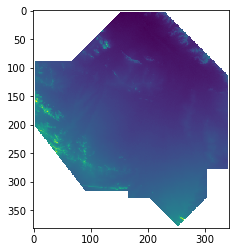

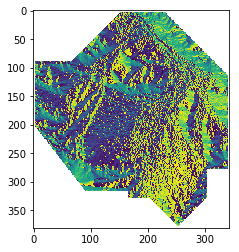

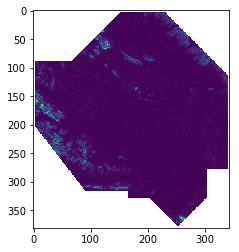

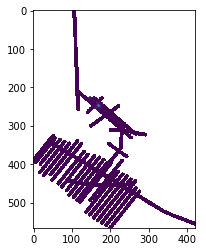

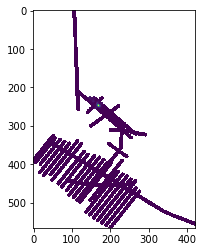

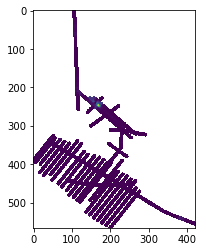

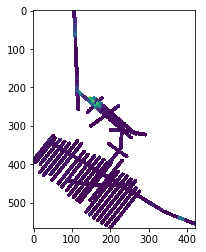

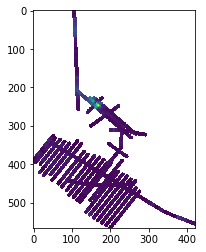

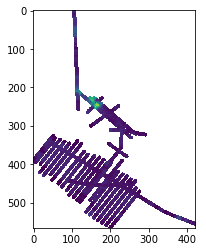

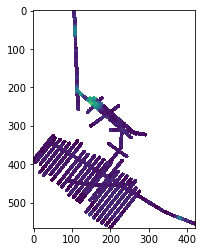

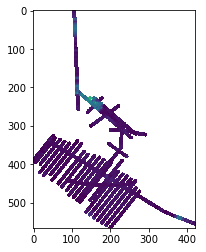

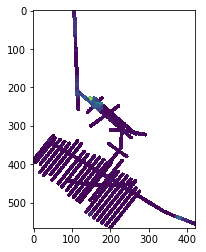

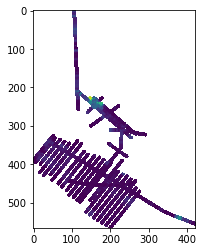

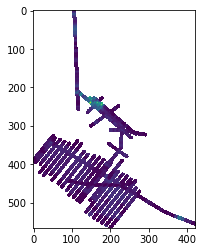

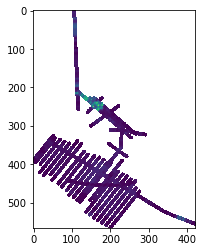

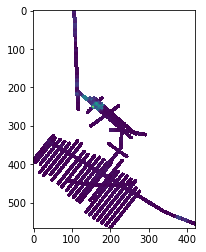

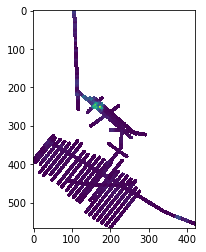

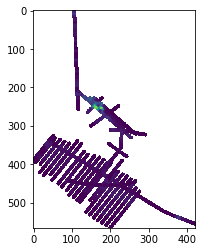

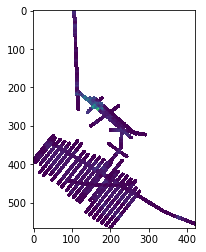

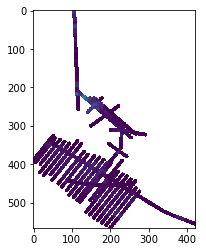

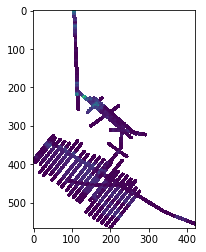

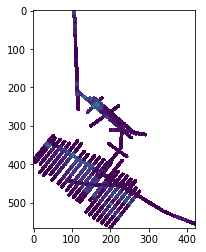

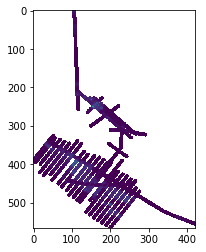

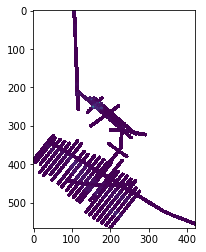

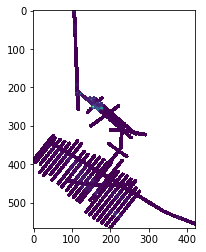

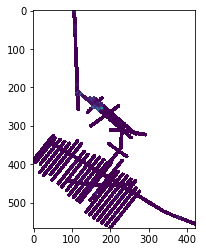

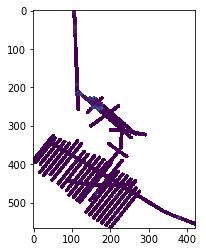

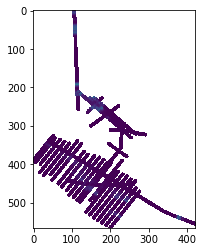

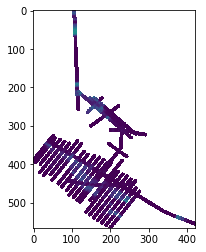

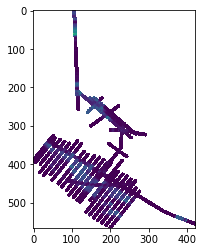

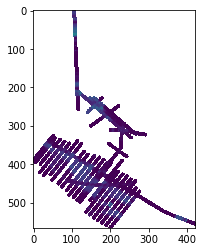

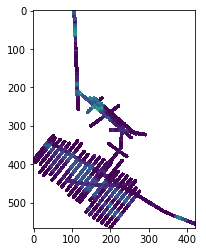

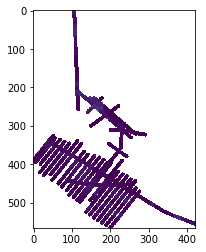

dict_keys(['elevation', 'aspect', 'slope', 'conductivity1_0.0', 'conductivity2_2.0', 'conductivity3_4.0', 'conductivity4_6.2', 'conductivity5_8.4', 'conductivity6_10.9', 'conductivity7_13.6', 'conductivity8_16.6', 'conductivity9_20.0', 'conductivity10_23.8', 'conductivity11_28.1', 'conductivity12_33.1', 'conductivity13_38.8', 'conductivity14_45.3', 'conductivity15_52.9', 'conductivity16_61.6', 'conductivity17_71.7', 'conductivity18_83.4', 'conductivity19_96.9', 'conductivity20_112.6', 'conductivity21_130.8', 'conductivity22_151.9', 'conductivity23_176.3', 'conductivity24_204.7', 'conductivity25_237.6', 'conductivity26_275.7', 'conductivity27_319.9', 'conductivity28_371.3', 'conductivity29_430.9', 'conductivity30_500.0'])

In [198]:
# dict to store the dataarrays in for conversion to dataset
dataarrays = {}

for datatype, file in alldatafiles.items():
    with rasterio.open(file) as src:
        # build the dict of useful attributes
        attribs = buildRasterAttributes(src)
        # build the coordinate lists
        x, y = buildAxesFromAttributes(attribs) 
        # read teh data, and reshape it to remove the 3rd dimension (ie band 1)
        # set to np.float32 to save space
        data = src.read().reshape(src.height, src.width).astype(np.float32)
        # boolean mask to change all "no data" values to np.nan
        data[data == attribs['nodata']] = np.nan
        # turn the data into an xarray dataarray with the relevant coordinates
        dataarrays[datatype] = xr.DataArray(data, [('y', y), ('x', x)])
        # set the attributes of the dataarray to the attributs of the parent raster
        dataarrays[datatype].attrs = attribs
        # update the attributes to the new nodata value
        dataarrays[datatype].attrs['nodata'] = np.nan
        
#         # check the data as it imports
#         imshow(data)
#         ax = plt.gca()
#         plt.show()
#         ax.set_xticklabels(x)
#         ax.set_yticklabels(y)
        
dataarrays.keys()

## Check the coarsest grid of the inputs, and regrid finer data to that spacing

In [201]:
def realignAndCoarsenGrids(dataarrays):
    """
    Takes a dict of data arrays.
    Loops through them, determines the largest grid cell size for all of them, and rescales all the other
    dataarrays to be this coarse and have the same bounds.
    
    Assumes (and checks) the CRS for all the data arrays are consistent
 
    """
    
    def calcMaxCoord(attrs, axis = 'x'):
        if axis == 'x':
            maxval = attrs['width'] * attrs['affine'].a + attrs['affine'].c
        if axis == 'y':
            maxval = attrs['height'] * attrs['affine'].e + attrs['affine'].f
        return maxval
    
    def transformToAffine(transform):
        return affine.Affine(transform[1], transform[2], transform[0], transform[4], transform[5], transform[3])
    
    def affineToTransform(affine):
        return [affine.c, affine.a, affine.b, affine.f, affine.d, affine.e]
    
    def CRSCompare(crs1, crs2):
        if crs1['proj'] == crs2['proj'] and crs1['zone'] == crs2['zone'] and crs1['south'] == crs2['south']:
            return True
        else:
            return False
    
    # initialise some key variables with details from one of the dataarrays (which one is irrelevant)
    inits = dataarrays[list(dataarrays.keys())[0]].attrs
    maxpixelsize = int(inits['affine'].a)
    firstCRS = inits.attrs['crs']
    coarsestgrid = list(dataarrays.keys())[0]
    
    for datatype, data in dataarrays.items():
        # check CRS matches the first
        if not CRSCompare(firstCRS, data.attrs['crs']):
            print('Inconsistent CRS. Please fix and try again')
            return
            
        # affine attributes are a, b, c, d, e, f, which align with indices 0:5 (inclusive)
        # x step, x rotation, x min value, y rotation, y step, y min value
        
        # if the current data is coarser than the current coarsest, update
        if data.attrs['affine'].a > maxpixelsize:
            maxpixelsize = int(data.attrs['affine'].a)
            coarsestgrid = datatype
    
    # find the top left coords of the coarse grid for comparison
    coarsestgrid = dataarrays[coarsestgrid].attrs['affine']
    coarseleft = int(coarsestgrid.c)
    coarsetop = int(coarsestgrid.f)
    
    for datatype, data in dataarrays.items():
        # do some stuff here to check if the bounds need to be extended
            # assume not at this point
        
        # 4 things to consider:
            # any overlap at all
            # grid size
            # start coordinates
            # extent
        # do as seperate tests to constuct newarr and dst_transform, then apply at end?
    
        # readjusting pixel size and origin location
        if maxpixelsize != data.attrs['affine'].a:
            # figure out how much to scale the data by
            scalefactor = maxpixelsize / data.attrs['affine'].a
            # make a placeholder array of the correct size filled with NaN
            newheight = int(data.shape[0] / scalefactor)
            newwidth = int(data.shape[1] / scalefactor)
            newarr = np.zeros(shape = (newheight, newwidth), dtype = np.float32) * np.nan     

            # update the cell size to the desired new size
            # need to swap from transforms to affines at some point...not sure how warp.reproject deals with this

#             dst_transform = affineToTransform(dataarrays[coarsestgrid].attrs['affine'])

            dst_transform = affineToTransform(data.attrs['affine'])
            print(datatype, 'dst_transform', dst_transform, 'coarsest transform:', affineToTransform(coarsestgrid))
            dst_transform[1] = dst_transform[1] * scalefactor
            dst_transform[5] = dst_transform[5] * scalefactor
            
            # update the start X and Y coordinates so they align with the coarsest grid           
            
            print('dst_transform after scaling', dst_transform)

            # set the dst_transform leftmost point to the value of the first coarse point to the right
            # finnicky logic about the + and - cases
            # pixel size is alwys positive, so need to make it deal with the negative steps for y by inverting signs            
            if coarseleft < data.attrs['affine'].c:
                dst_transform[0] = range(coarseleft, int(data.attrs['affine'].c + maxpixelsize), maxpixelsize)[-1]
            
            elif data.attrs['affine'].c < coarseleft:
                dst_transform[0] = range(coarseleft, int(data.attrs['affine'].c), -maxpixelsize)[-1]
                
            if coarsetop < data.attrs['affine'].f:
                dst_transform[3] = range(coarsetop, int(data.attrs['affine'].f), maxpixelsize)[-1]
            
            elif data.attrs['affine'].f < coarsetop:
                dst_transform[3] = range(coarsetop, int(data.attrs['affine'].f) - maxpixelsize, - maxpixelsize)[-1]
                
    
            print('dst_transform after realignment', dst_transform)

            # use the rasterio wrapper for gdal warp
            warp.reproject(data.values,
                               newarr,
                               src_transform = affineToTransform(data.attrs['affine']),
                               dst_transform = dst_transform,
                               src_crs = data.attrs['crs'],
                               dst_crs = data.attrs['crs'],
                              resampling = warp.Resampling.bilinear)
            
            axisbuilding = {'affine' : transformToAffine(dst_transform),
                            'width' : newwidth,
                            'height' : newheight,
                            'count' : 1,
                            'crs' : data.crs,
                            'nodata' : data.attrs['nodata']}
            x, y = buildAxesFromAttributes(axisbuilding)
            
            dataarrays[datatype] = xr.DataArray(newarr, [('y', y), ('x', x)])
            dataarrays[datatype].attrs = axisbuilding

In [202]:
# operates in place and returns nothing
realignAndCoarsenGrids(dataarrays)

# get the conductivtiy data into a single dataarray
# concatenate all the conductivity grids together along a new axis with top depth as index
# list comprehension for building the list of single conductivity dataarrays
c = xr.concat([dataarrays[condgrid] for condgrid in aem_layernames], aem_top_depths)
# rename new dimension to depth
c = c.rename({'concat_dim':'z'})
# delete the now uneeded count of number of bands.. ## delete this from all dataarrays?
del c.attrs['count']
# assign new dataarray to the dict
dataarrays['conductivity'] = c
# drop the existing single conductivity layer dataarrays by dict comprehension making a new dict without them
dataarrays = {name: data for name, data in dataarrays.items() if name not in aem_layernames}

ds = xr.Dataset(dataarrays)
# clearing up some memory
del dataarrays
ds

<xarray.Dataset>
Dimensions:       (x: 452, y: 604, z: 30)
Coordinates:
  * y             (y) float64 7.449e+06 7.449e+06 7.45e+06 7.45e+06 ...
  * x             (x) float64 2.886e+05 2.89e+05 2.894e+05 2.898e+05 ...
  * z             (z) float64 0.0 2.0 4.0 6.2 8.4 10.9 13.6 16.6 20.0 23.8 ...
Data variables:
    elevation     (y, x) float32 nan nan nan nan nan nan nan nan nan nan nan ...
    aspect        (y, x) float32 nan nan nan nan nan nan nan nan nan nan nan ...
    slope         (y, x) float32 nan nan nan nan nan nan nan nan nan nan nan ...
    conductivity  (z, y, x) float32 nan nan nan nan nan nan nan nan nan nan ...

In [204]:
# get the data ready for ML

# goal is a data frame with columns x, y, aspect, slope, elevation, conds 1-30

# create an empty list to store the results in
dfs = []
for feature in list(ds.data_vars):
    # assume that every dataarray has at least X and Y
    # for those that only have X and Y:
    if len(ds[feature].coords) == 2:
        dfs.append(ds[feature].to_dataframe())   
    else:
        # otherwise loop thorugh all the other dimensions
        other_dims = [dim for dim in list(ds[feature].coords) if dim not in ['x','y']]
        for dim in other_dims:
            # loop through all the instances of the other dimensions
            for i in range(len(ds[feature][dim].values)):
                df = ds[feature][i].to_dataframe()
                new_cols = list(df.columns)
                # do some funkiness to track which column is which
                new_cols[1] = new_cols[1] + '_' + str(df.iloc[0,0])
                df.columns = new_cols
                # drop this uneeded column
                df = df.drop([df.columns[0]], axis = 1)
                dfs.append(df)
                
# bring it all together
df = pd.concat(dfs, axis = 1)
# free up some memory
del dfs

# reset index so X and Y can be used as features
df = df.reset_index()
# need to use sin and cos of aspect because of the circular nature of it
# (ie 359 and 001 are as close as 90 and 92)
df['aspect_sin'] = np.sin(df['aspect'] * (np.pi / 180))
df['aspect_cos'] = np.cos(df['aspect'] * (np.pi / 180))
# this column not needed now
df = df.drop(['aspect'], axis = 1)

# have a look at the columns with valid data
df[np.isfinite(df).all(axis = 1)]

,y,x,elevation,slope,conductivity_0.0,conductivity_2.0,conductivity_4.0,conductivity_6.2,conductivity_8.4,conductivity_10.9,...,conductivity_176.3,conductivity_204.7,conductivity_237.6,conductivity_275.7,conductivity_319.9,conductivity_371.3,conductivity_430.9,conductivity_500.0,aspect_sin,aspect_cos
17401,7464200.0,378600.0,665.468567,0.105027,0.003964,0.004054,0.004390,0.004734,0.004937,0.005197,...,0.011574,0.003058,0.000973,0.000789,0.001198,0.002218,0.002919,0.003048,-0.832762,0.553631
17402,7464200.0,379000.0,666.188293,0.163783,0.002279,0.002358,0.002672,0.003081,0.003535,0.004067,...,0.005818,0.002883,0.000636,0.000433,0.000595,0.000983,0.001296,0.001792,-0.935297,0.353864
17403,7464200.0,379400.0,667.913391,0.233140,0.002798,0.002945,0.003417,0.004107,0.005003,0.006235,...,0.002632,0.001510,0.000473,0.000356,0.000467,0.000716,0.000933,0.001436,-0.775363,0.631516
17404,7464200.0,379800.0,668.575073,0.187201,0.003060,0.003221,0.003741,0.004572,0.005672,0.007201,...,0.002744,0.001616,0.000536,0.000413,0.000541,0.000814,0.001049,0.001659,-0.134589,0.990902
17405,7464200.0,380200.0,668.412720,0.266367,0.003034,0.003163,0.003611,0.004281,0.005127,0.006240,...,0.003994,0.002087,0.000641,0.000488,0.000645,0.000977,0.001245,0.001817,-0.822259,0.569114
17406,7464200.0,380600.0,671.877197,0.348579,0.003107,0.003215,0.003612,0.004154,0.004765,0.005478,...,0.005820,0.002623,0.000741,0.000550,0.000747,0.001198,0.001552,0.002143,-0.948853,0.315720
17407,7464200.0,381000.0,673.727600,0.287145,0.002906,0.003056,0.003550,0.004320,0.005418,0.007022,...,0.002454,0.001510,0.000528,0.000427,0.000563,0.000803,0.000998,0.001496,-0.853498,0.521097
17408,7464200.0,381400.0,675.457642,0.386399,0.003506,0.003723,0.004372,0.005453,0.007168,0.009987,...,0.001417,0.000938,0.000469,0.000447,0.000594,0.000777,0.000927,0.001348,-0.721228,0.692698
17409,7464200.0,381800.0,677.942810,0.397250,0.003815,0.004054,0.004754,0.005962,0.007991,0.011494,...,0.001147,0.000788,0.000475,0.000503,0.000677,0.000840,0.000972,0.001370,-0.662851,0.748752
17410,7464200.0,382200.0,679.817810,0.358923,0.003907,0.004143,0.004835,0.006035,0.008127,0.011799,...,0.001086,0.000746,0.000487,0.000544,0.000744,0.000901,0.001034,0.001415,-0.617605,0.786489


In [40]:
ds_orig = xr.Dataset(dataarrays_orig)
ds = xr.Dataset(dataarrays)

def drawDEM(ds, varname, figsize = [10,10]):
    fig = plt.figure(figsize = figsize)
    imshow(ds[varname].values)
    ax = plt.gca()
    ax.set_xticklabels(np.around(ds.x.values,-1))
    ax.set_yticklabels(np.around(ds.y.values, -1))
    ax.set_title(varname)
    ax.invert_yaxis()
    plt.colorbar()
    plt.show()

Exception ignored in: 'zmq.backend.cython.message.Frame.__dealloc__'
Traceback (most recent call last):
  File "zmq/backend/cython/checkrc.pxd", line 12, in zmq.backend.cython.checkrc._check_rc (zmq\backend\cython\message.c:4294)
    PyErr_CheckSignals()
KeyboardInterrupt


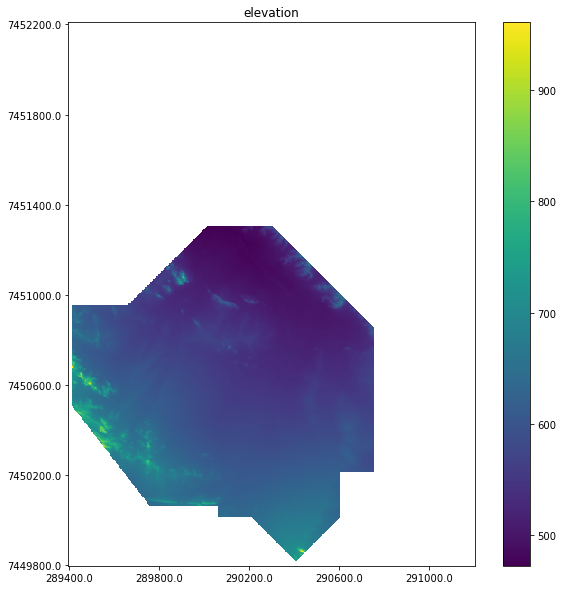

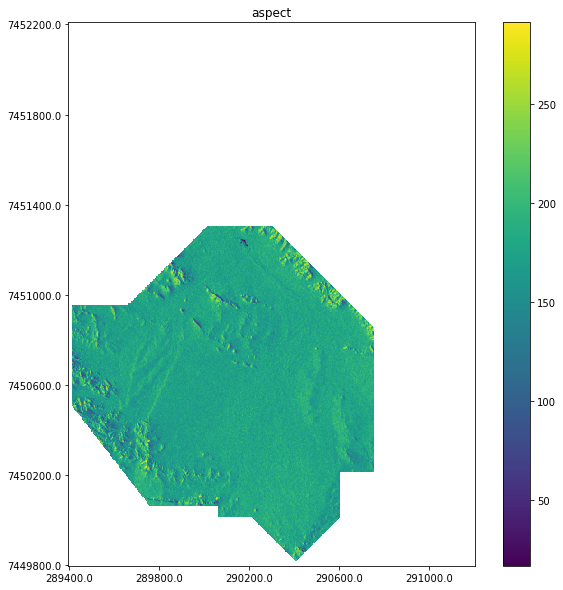

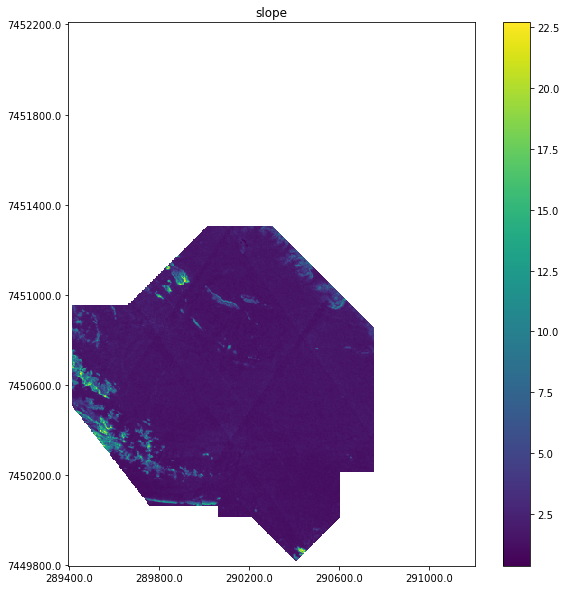

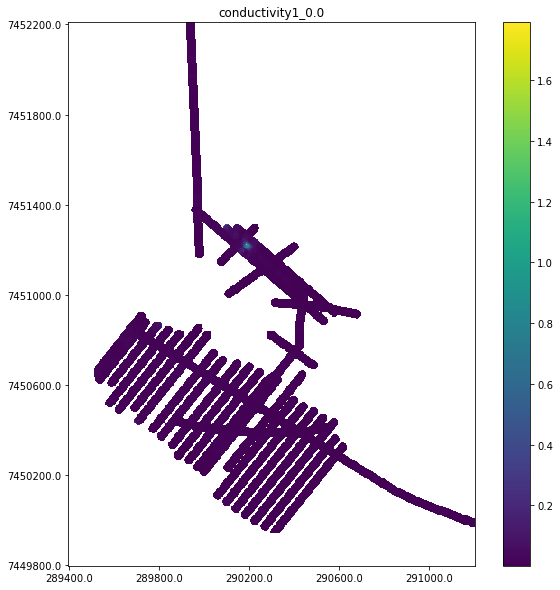

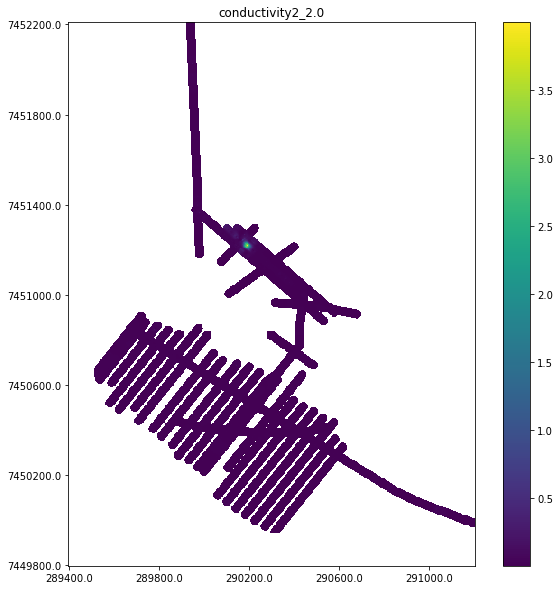

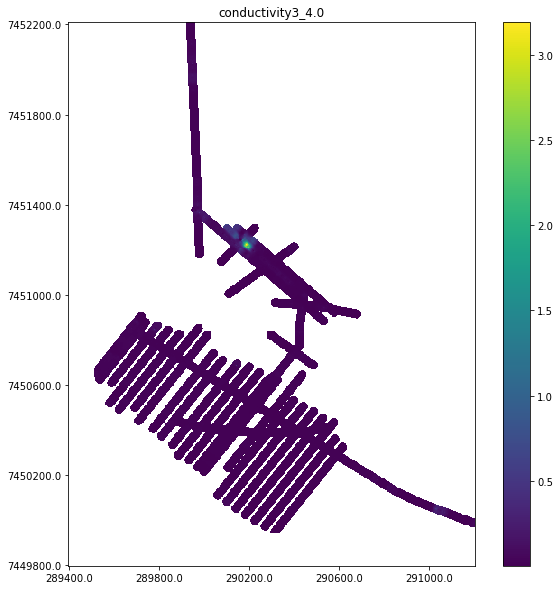

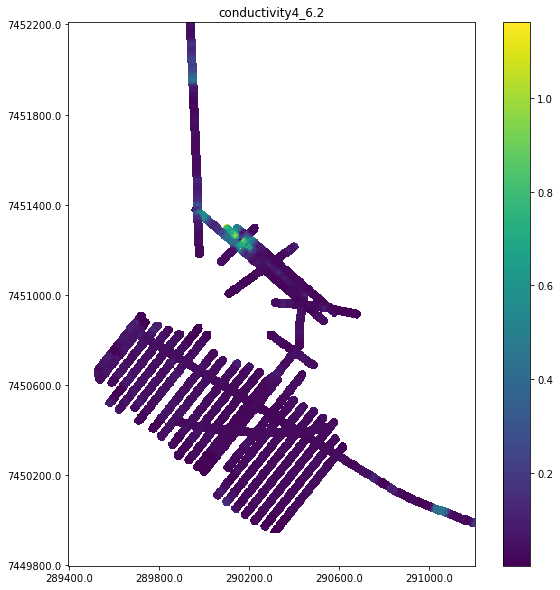

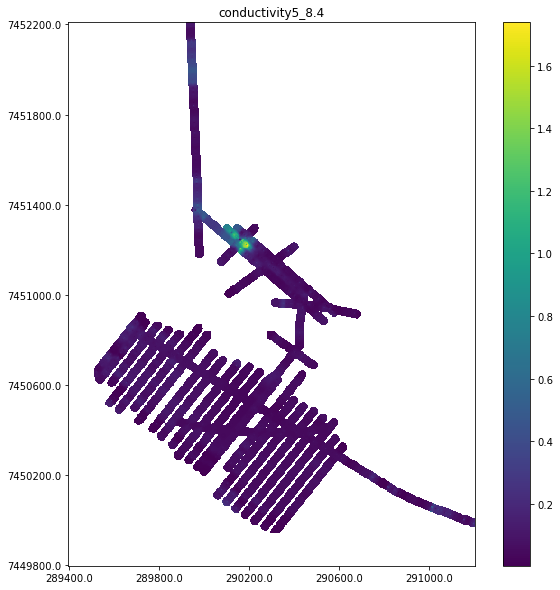

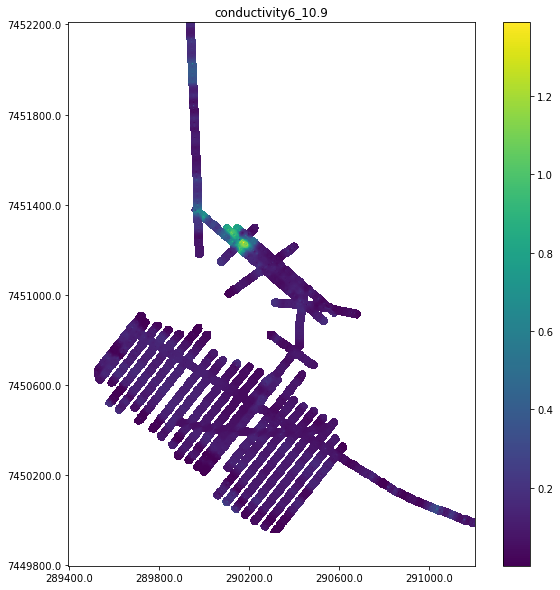

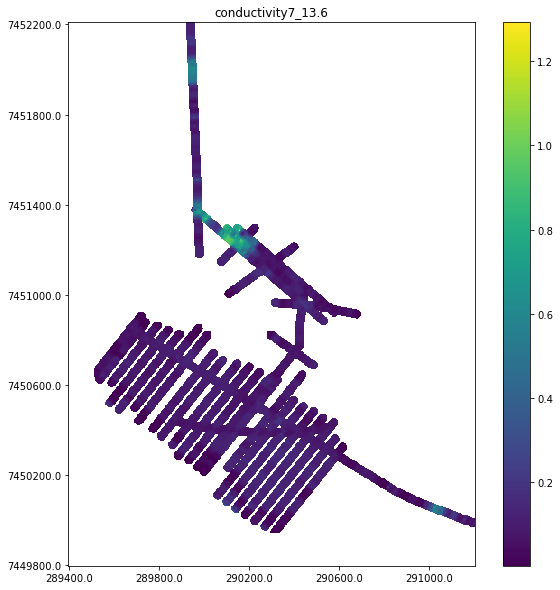

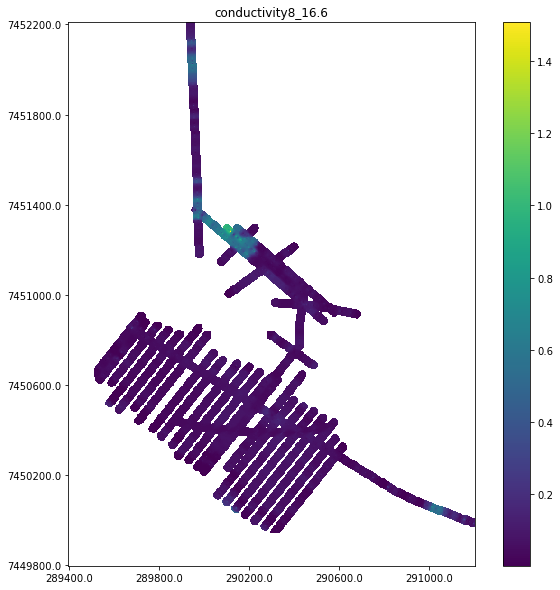

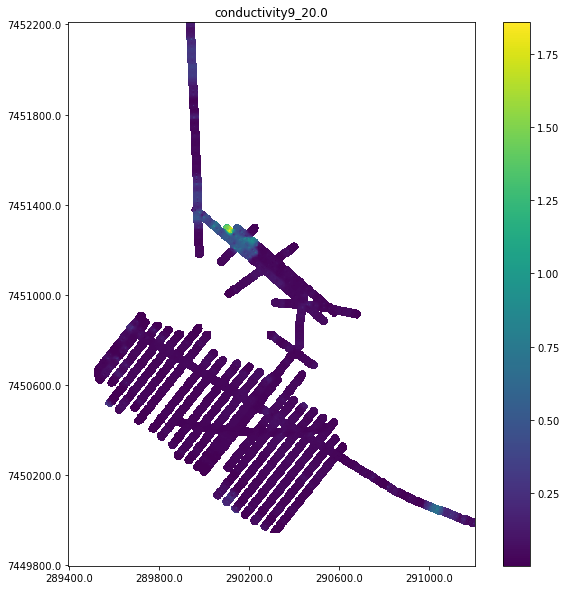

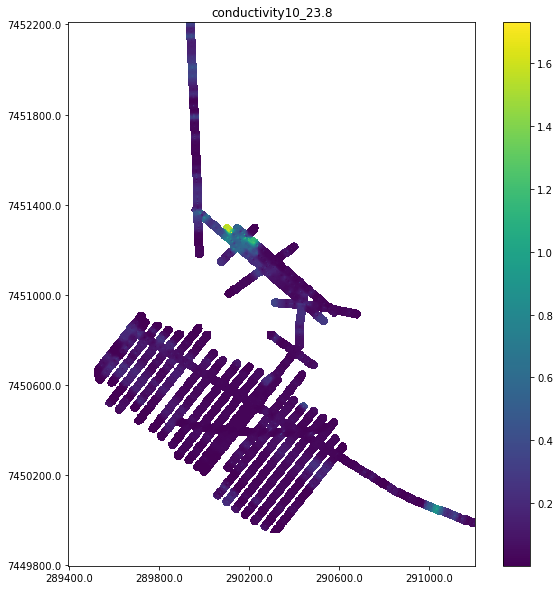

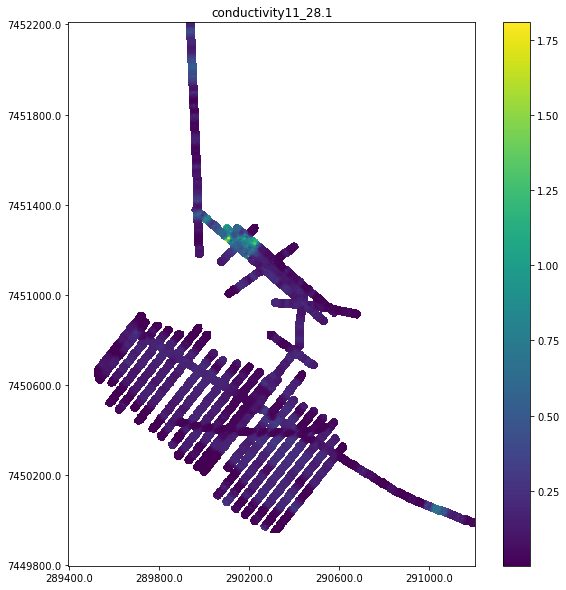

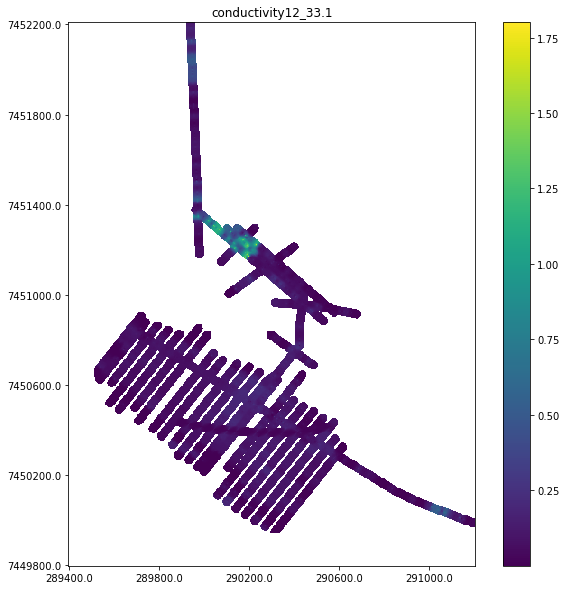

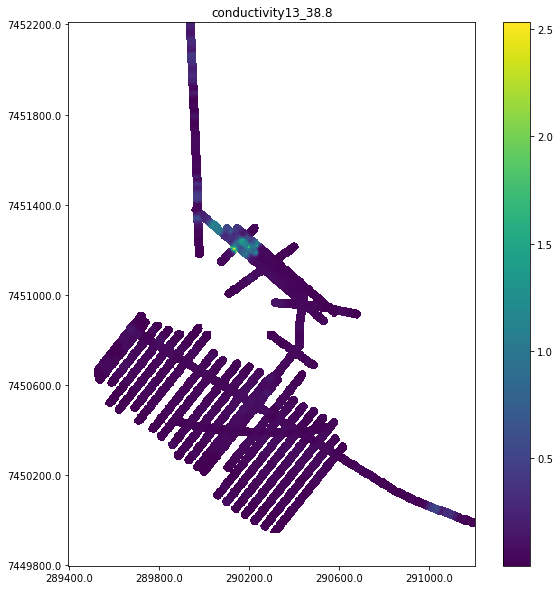

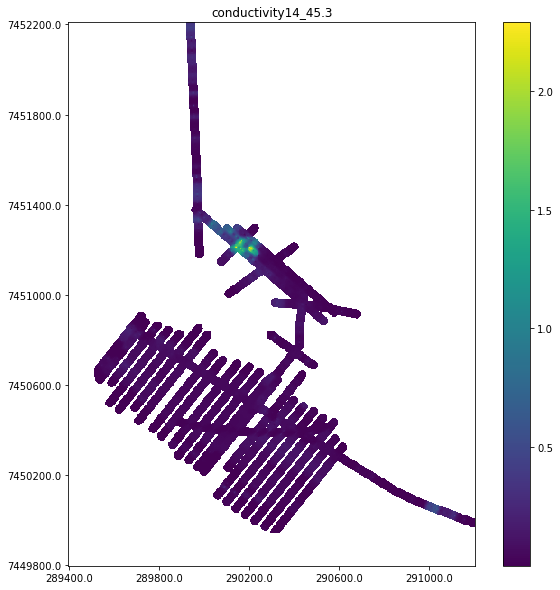

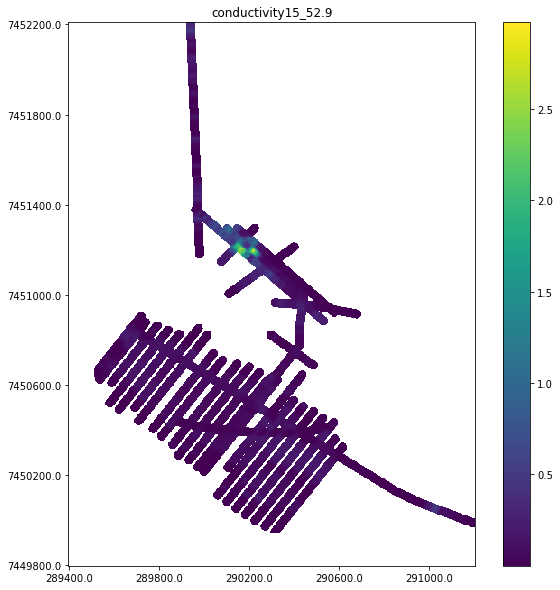

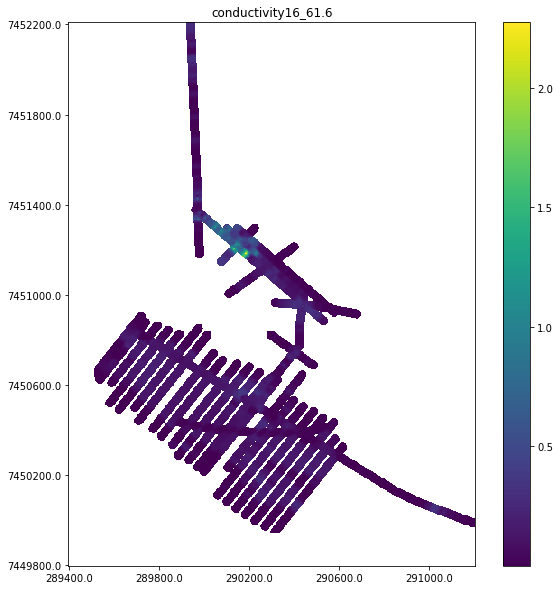

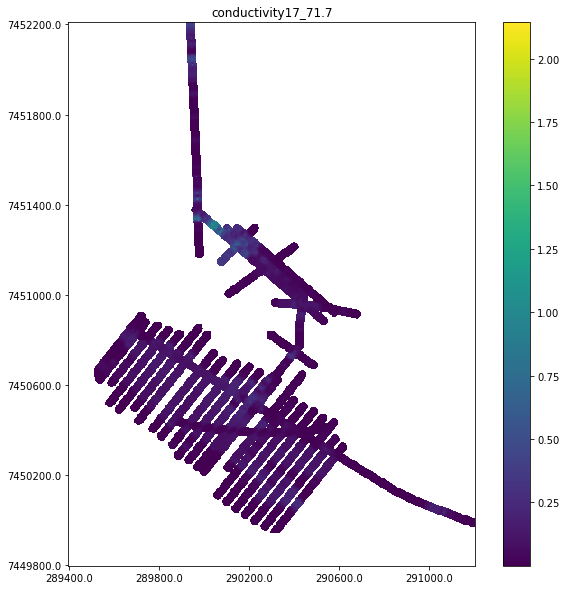

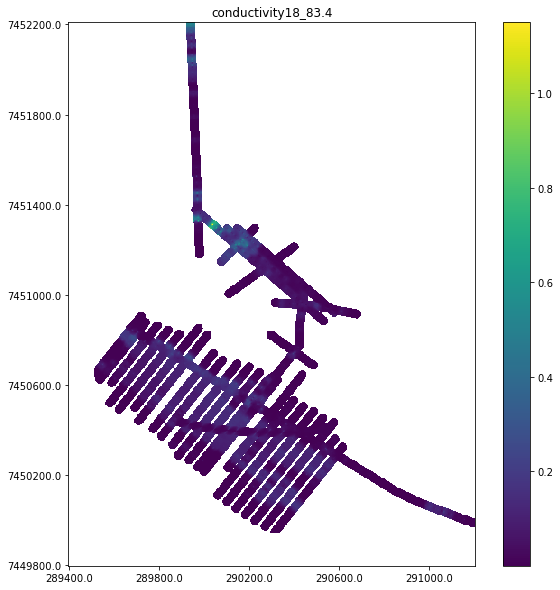

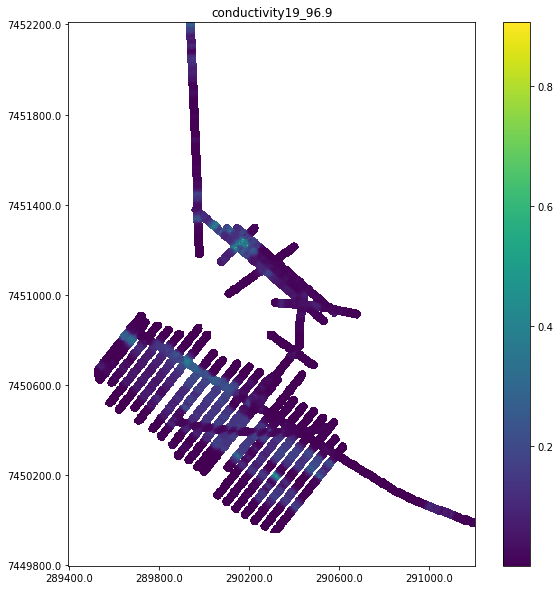

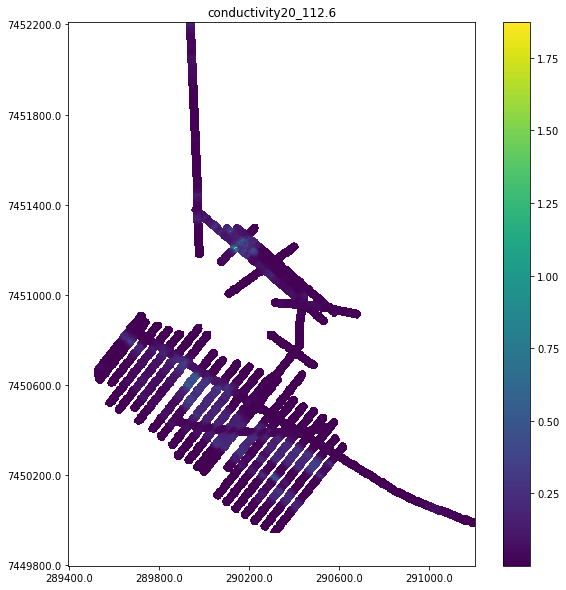

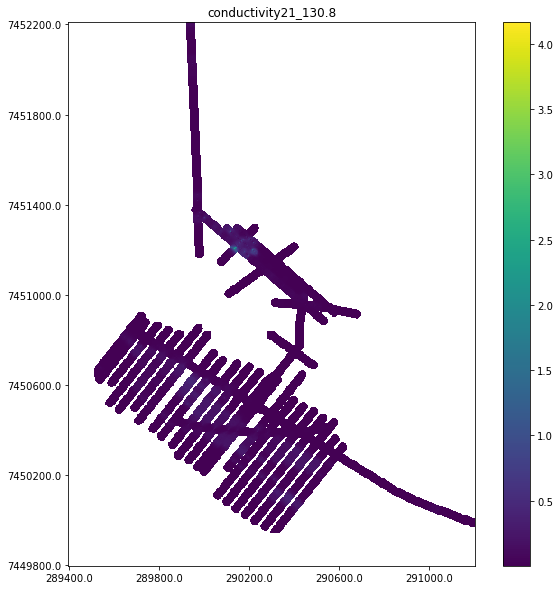

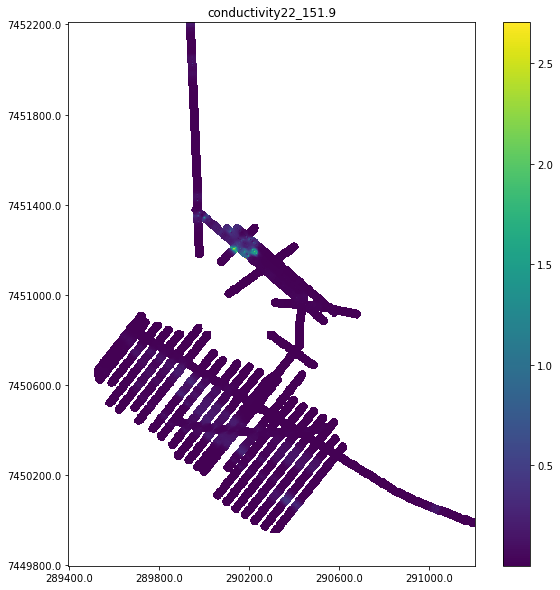

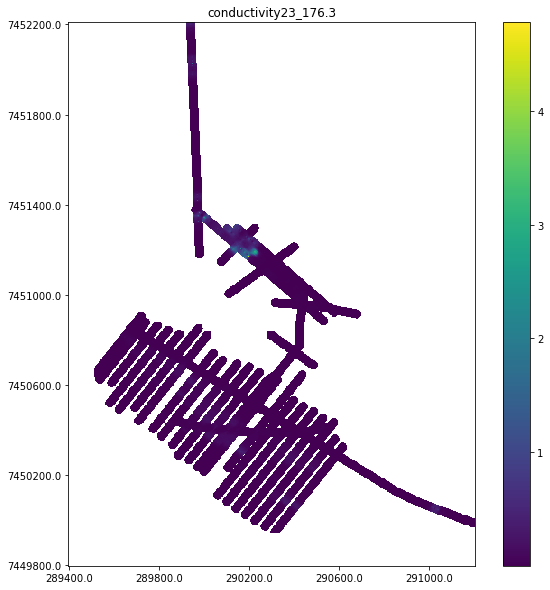

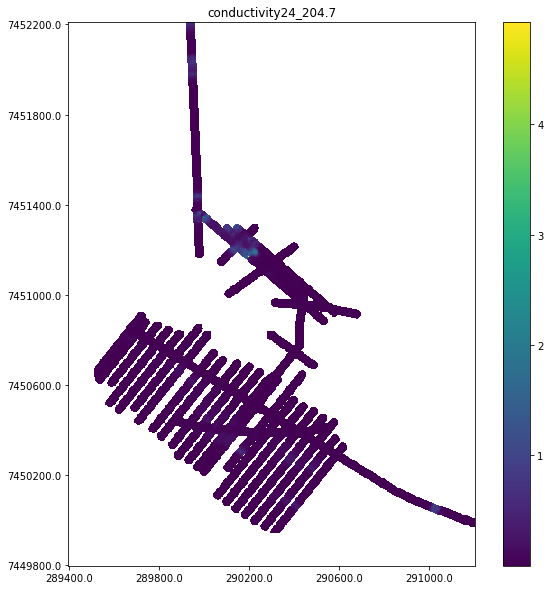

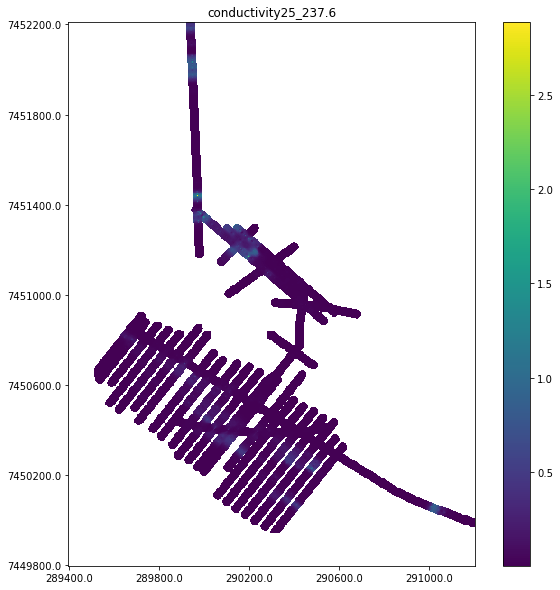

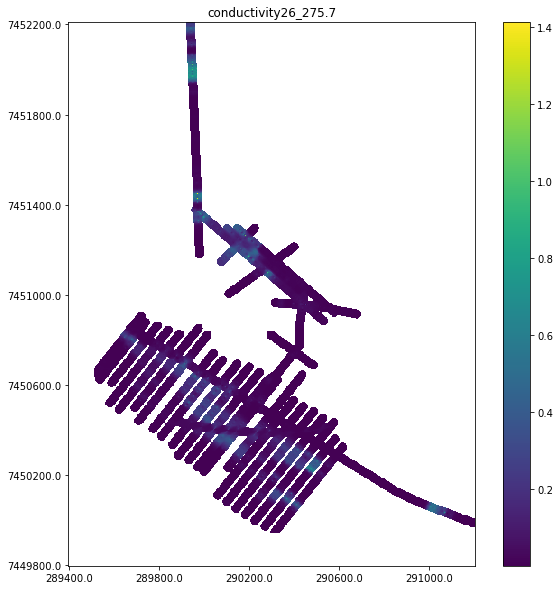

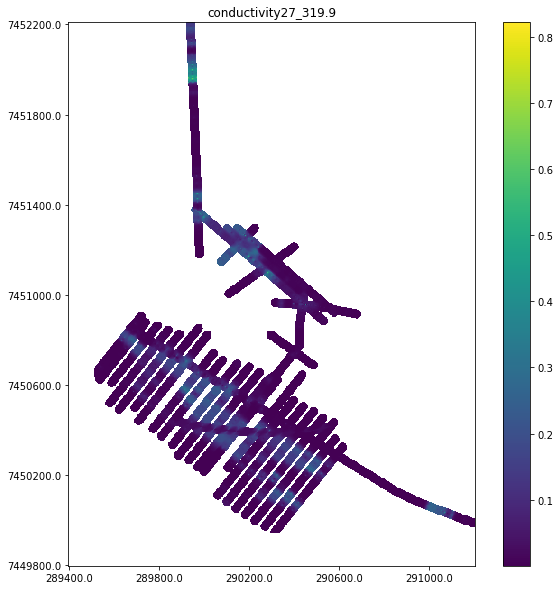

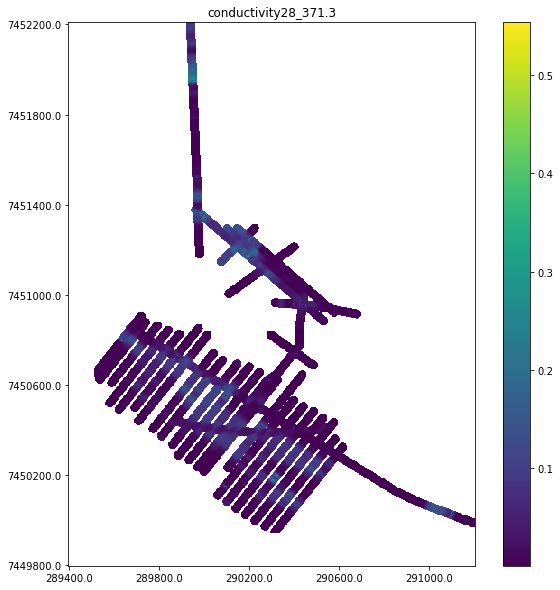

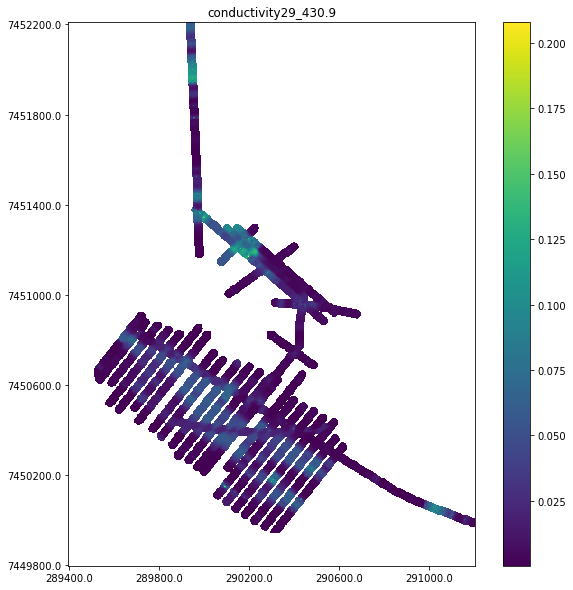

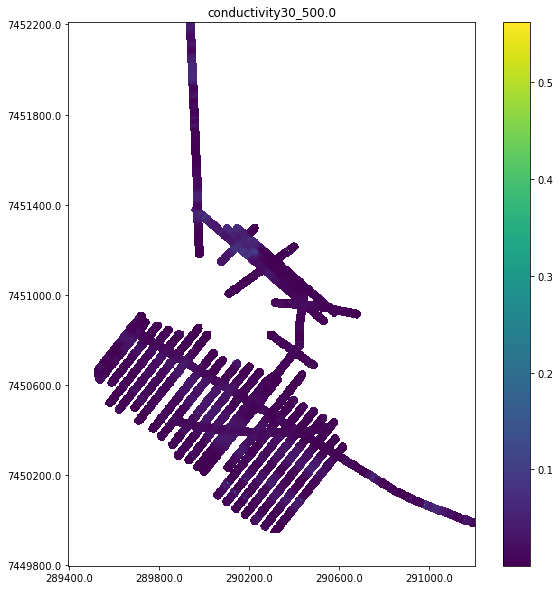

In [41]:
for dtype in alldatafiles.keys():
#     drawDEM(ds_orig, dtype)
    drawDEM(ds, dtype)